# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
fifa.dropna(inplace=True)
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [6]:
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122529,66.249904,71.319126,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.670568,6.914613,6.134420,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [7]:
fifa_faltante = pd.DataFrame({
    'coluna': fifa.columns,
    'faltante_quantidade': fifa.isna().sum(),
    'faltante_percentual': fifa.isna().sum()/fifa.shape[0]
})
fifa_faltante

,coluna,faltante_quantidade,faltante_percentual
Age,Age,0,0.0
Overall,Overall,0,0.0
Potential,Potential,0,0.0
Crossing,Crossing,0,0.0
Finishing,Finishing,0,0.0
HeadingAccuracy,HeadingAccuracy,0,0.0
ShortPassing,ShortPassing,0,0.0
Volleys,Volleys,0,0.0
Dribbling,Dribbling,0,0.0
Curve,Curve,0,0.0


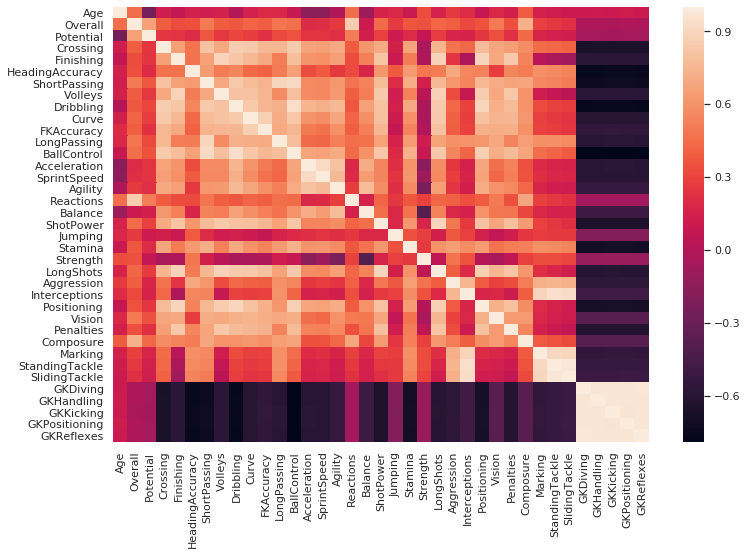

In [8]:
ax = sns.heatmap(fifa.corr());

# Visualizar os dados em 2d

Utizando PCA para 2 componentes

In [9]:
# Applying pca to the fifa dataset with the intention of transforming it into two dimensions
pca = PCA(n_components=2)
fifa_pca = pd.DataFrame(pca.fit_transform(fifa.dropna(axis=0).values), columns=['pca1', 'pca2'])

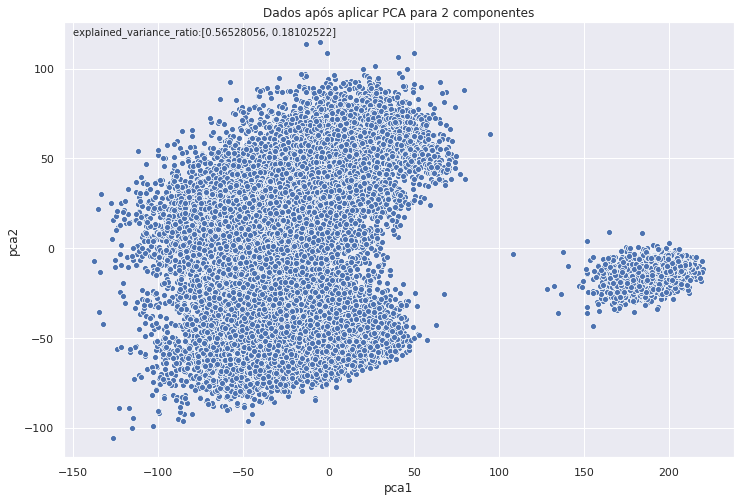

In [10]:
# Plotting result pca
ax_pca = sns.scatterplot(x=fifa_pca['pca1'], y=fifa_pca['pca2'])
plt.title('Dados após aplicar PCA para 2 componentes')

ax_pca.text(-150, 119,'explained_variance_ratio:[0.56528056, 0.18102522]', fontsize=10) 
plt.show()

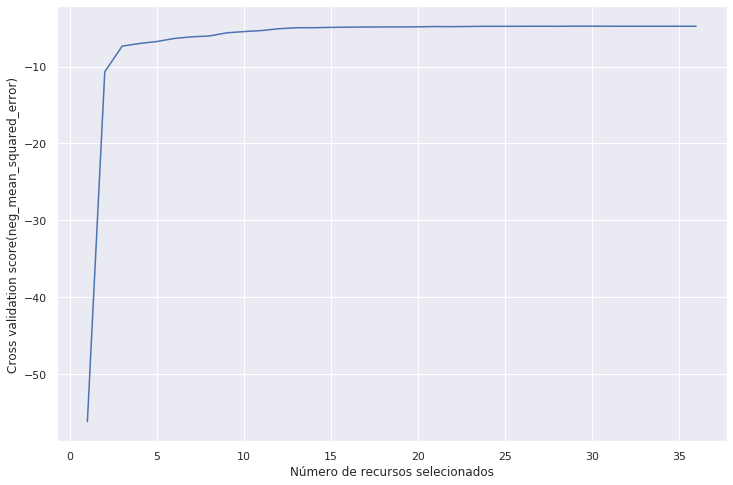

In [11]:
X = fifa.drop(['Overall'], axis=1)
y = fifa.Overall

model_rfecv = RFECV(LinearRegression(), step=1, cv=5, scoring='neg_mean_squared_error')
model_rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Número de recursos selecionados")
plt.ylabel("Cross validation score(neg_mean_squared_error)")
plt.plot(range(1, len(model_rfecv.grid_scores_) + 1), model_rfecv.grid_scores_)
plt.show()

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [12]:
def q1():
    return round(float(PCA(n_components=1).fit(fifa.values).explained_variance_ratio_[0]), 3)

q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [13]:
def q2():
    return int(PCA(n_components=0.95).fit(fifa.values).n_components_)

q2()

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [14]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [15]:
def q3():
    return tuple(PCA(n_components=2).fit(fifa.values).components_.dot(x).round(3))

q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [16]:
def q4():
    X = fifa.drop(['Overall'], axis=1)
    y = fifa.Overall

    model_rfe = RFE(LinearRegression(), n_features_to_select=5, step=1)
    model_rfe.fit(X, y)
    return [X.columns[idx] for idx in range(len(model_rfe.ranking_)) if model_rfe.ranking_[idx] == 1]

q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']